In [1]:
!pip install nltk -q
!pip install lightgbm -q


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from lightgbm import LGBMClassifier

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\taras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taras\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\taras\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [56]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
sns.set_palette(sns.color_palette("Set2"))
RANDOM_STATE = 42

In [4]:
data_fake = pd.read_csv('data/Fake.csv')
data_true = pd.read_csv('data/True.csv')

In [5]:
data_fake['target'] = 1

In [6]:
data_fake.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [7]:
data_true['target'] = 0

In [8]:
data_true.head(15)

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017",0
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",0
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",0
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",0
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017",0


обратим внимание на WASHINGTON (Reuters) - подобная конструкция встречается в начале каждой True новости. Это необходимо убрать

In [9]:
data =  pd.concat([data_fake, data_true])

In [10]:
data.sample(5)

,title,text,subject,date,target
5208,This Roofing Company Wants To Arm All Its Cus...,"When you think of roofs and AR-15s, a great ma...",News,"August 2, 2016",1
5676,Trump aide cites 'massacre' that never occurre...,(Reuters) - A Trump administration aide correc...,politicsNews,"February 3, 2017",0
8001,"Obama names U.S. ambassador to Cuba, setting u...",WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,"September 27, 2016",0
17338,Chance of 'no deal' Brexit rises to 1-in-4: JP...,LONDON (Reuters) - The probability that Britai...,worldnews,"October 16, 2017",0
22984,Hollywood Hip to Al Qaeda: ‘And the Oscar for ...,Alex Christoforou The DuranIt should come as ...,Middle-east,"February 28, 2017",1


# data analysis

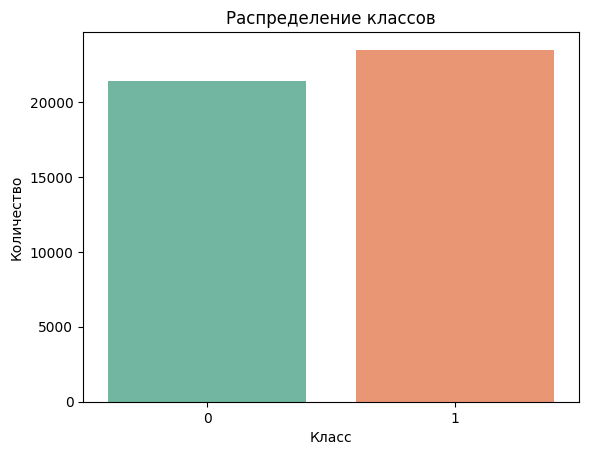

In [11]:
sns.barplot(x=data['target'].value_counts().index, y=data['target'].value_counts().values)
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


Посмотрим на количество пропусков

In [13]:
data.isna().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

Проверяем на дубликаты

In [14]:
print("Количество дубликатов")
data.duplicated().sum()

Количество дубликатов


209

Нам не нужны дубликаты, поэтому мы их удаляем

In [15]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

In [16]:
data['full_text'] = data["title"] + ' ' + data["text"]

In [17]:
data.sample(5)

,title,text,subject,date,target,full_text
21197,#BlackLivesMatterTerrorists Shut Down Kids Vis...,These poor kids have probably practiced for mo...,left-news,"Dec 23, 2015",1,#BlackLivesMatterTerrorists Shut Down Kids Vis...
11180,WATCH MSNBC LIBERAL HACKS Claim Conspiracy Bet...,Have these two been watching the news?The Russ...,politics,"Apr 8, 2017",1,WATCH MSNBC LIBERAL HACKS Claim Conspiracy Bet...
16839,"U.N. torture watchdog ends trip to Rwanda, cit...",KIGALI (Reuters) - The U.N. subcommittee on to...,worldnews,"October 21, 2017",0,"U.N. torture watchdog ends trip to Rwanda, cit..."
4912,"Senate confirms Trump intelligence nominee, se...",WASHINGTON (Reuters) - The U.S. Senate voted o...,politicsNews,"March 15, 2017",0,"Senate confirms Trump intelligence nominee, se..."
14760,Coup? What coup? Zimbabwe's Herald misses army...,HARARE (Reuters) - In the annals of missed sto...,worldnews,"November 15, 2017",0,Coup? What coup? Zimbabwe's Herald misses army...


In [18]:
print("Уникальные значения в колонке 'subject':")
print(data['subject'].unique())
print(f"\nКоличество уникальных тем: {data['subject'].nunique()}")

Уникальные значения в колонке 'subject':
['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east'
 'politicsNews' 'worldnews']

Количество уникальных тем: 8


In [19]:
print("Распределение новостей по темам (общее):")
subject_counts = data['subject'].value_counts()
print(subject_counts)

Распределение новостей по темам (общее):
subject
politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


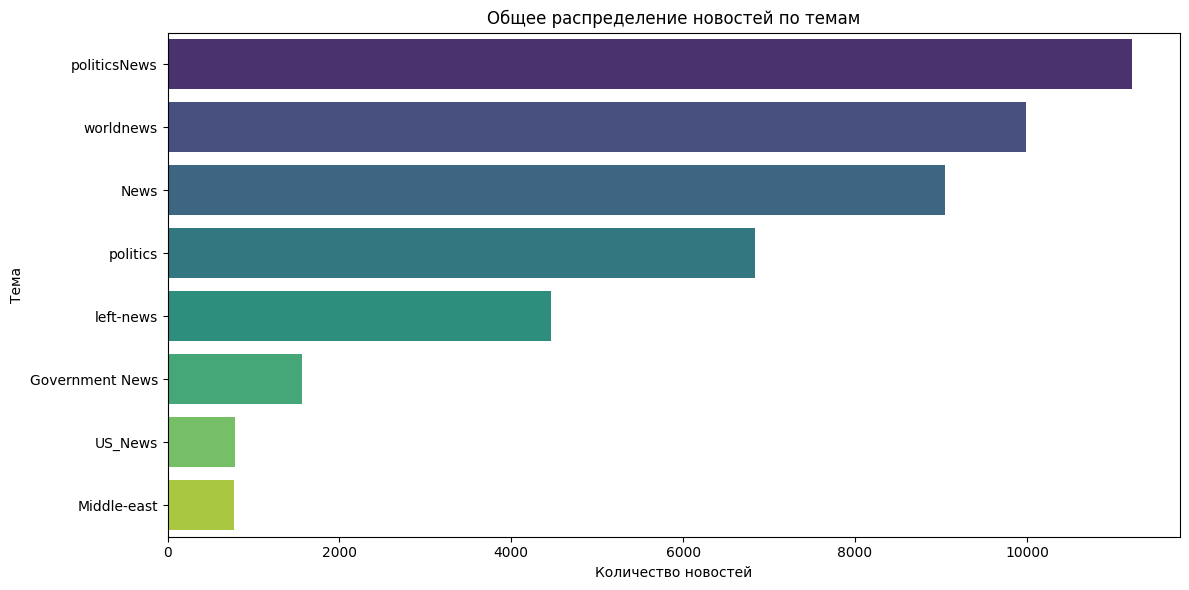

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(y='subject', data=data, order=subject_counts.index, palette='viridis')
plt.title('Общее распределение новостей по темам')
plt.xlabel('Количество новостей')
plt.ylabel('Тема')
plt.tight_layout()
plt.show()

Распределение тем по классам (target):
target               0     1
subject                     
Government News      0  1570
Middle-east          0   778
News                 0  9050
US_News              0   783
left-news            0  4459
politics             0  6838
politicsNews     11220     0
worldnews         9991     0


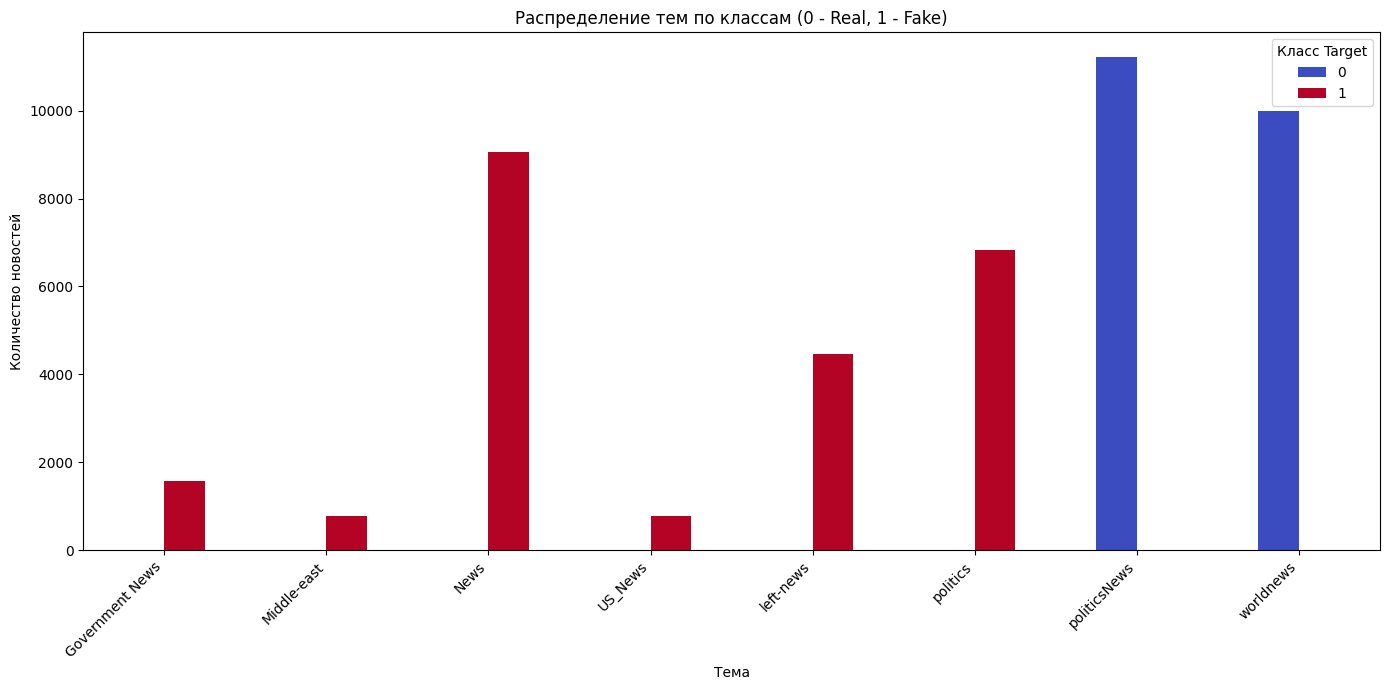

In [21]:
print("Распределение тем по классам (target):")
subject_target_crosstab = pd.crosstab(data['subject'], data['target'])
print(subject_target_crosstab)

subject_target_crosstab.plot(kind='bar', figsize=(14, 7), colormap='coolwarm')
plt.title('Распределение тем по классам (0 - Real, 1 - Fake)')
plt.xlabel('Тема')
plt.ylabel('Количество новостей')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Класс Target')
plt.tight_layout()
plt.show()

In [22]:
print("\nТемы, встречающиеся только в одном классе:")
for subject_name in subject_target_crosstab.index:
    counts = subject_target_crosstab.loc[subject_name]
    if counts[0] == 0 and counts[1] > 0:
        print(f"Тема '{subject_name}' встречается только в фейковых новостях (target=1), количество: {counts[1]}")
    elif counts[1] == 0 and counts[0] > 0:
        print(f"Тема '{subject_name}' встречается только в настоящих новостях (target=0), количество: {counts[0]}")


Темы, встречающиеся только в одном классе:
Тема 'Government News' встречается только в фейковых новостях (target=1), количество: 1570
Тема 'Middle-east' встречается только в фейковых новостях (target=1), количество: 778
Тема 'News' встречается только в фейковых новостях (target=1), количество: 9050
Тема 'US_News' встречается только в фейковых новостях (target=1), количество: 783
Тема 'left-news' встречается только в фейковых новостях (target=1), количество: 4459
Тема 'politics' встречается только в фейковых новостях (target=1), количество: 6838
Тема 'politicsNews' встречается только в настоящих новостях (target=0), количество: 11220
Тема 'worldnews' встречается только в настоящих новостях (target=0), количество: 9991


Вывод: поскольку все темы встречаются только в одном классе, нам нет необходимости их использовать для обучения классификатора, иначе будет утечка данных

# Обработка текста

In [23]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [24]:
def remove_problematic_patterns(text_input):
    cleaned_text = text_input 
    cleaned_text = re.sub(r"^[A-Za-z\s/]+\(Reuters\)\s*-\s*", "", cleaned_text, count=1)
    cleaned_text = re.sub(r"^\(Reuters\)\s*-\s*", "", cleaned_text, count=1)

    twitter_disclaimer = "The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS. The opinions expressed are his own. Reuters has not edited the statements or confirmed their accuracy."
    cleaned_text = re.sub(r"^" + re.escape(twitter_disclaimer) + r"\s*", "", cleaned_text, count=1)

    return cleaned_text.strip()

In [25]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    
    processed_tokens = []
    for word in tokens:
        if word not in stop_words:
            if word.isalpha(): 
                lemmatized_word = lemmatizer.lemmatize(word)
                processed_tokens.append(lemmatized_word)
                
    return " ".join(processed_tokens)

In [26]:
data['full_text_cleaned'] = data['full_text'].apply(remove_problematic_patterns)

In [27]:
data['processed_text'] = data['full_text_cleaned'].apply(preprocess_text)

Статистика по длине текста (в словах) для каждого класса:
          count        mean         std  min    25%    50%    75%     max
target                                                                   
0       21211.0  230.874405  158.114282  4.0   92.0  215.0  310.0  2333.0
1       23469.0  239.323959  228.537815  3.0  141.0  205.0  281.0  4831.0


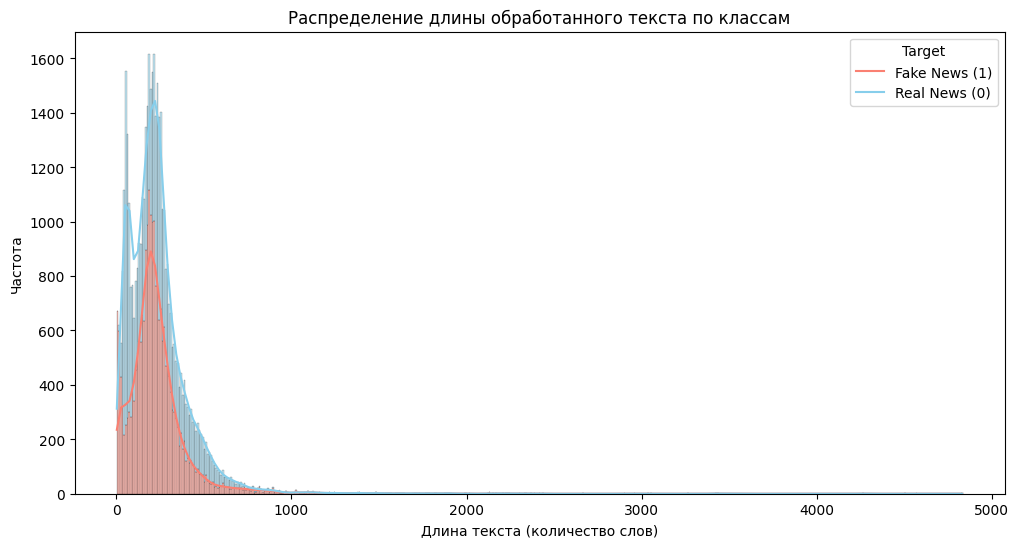

In [57]:
data['processed_text_length'] = data['processed_text'].apply(lambda x: len(x.split()))
print("Статистика по длине текста (в словах) для каждого класса:")
print(data.groupby('target')['processed_text_length'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='processed_text_length', hue='target', kde=True, palette={0: 'skyblue', 1: 'salmon'}, multiple="stack") # или multiple="dodge"
plt.title('Распределение длины обработанного текста по классам')
plt.xlabel('Длина текста (количество слов)')
plt.ylabel('Частота')
plt.legend(title='Target', labels=['Fake News (1)', 'Real News (0)']) # sns может сам подписать, но для уверенности
plt.show()

In [28]:
data.head()

,title,text,subject,date,target,full_text,full_text_cleaned,processed_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump Sends Out Embarrassing New Year’s...,donald trump sends embarrassing new year eve m...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,Drunk Bragging Trump Staffer Started Russian ...,Drunk Bragging Trump Staffer Started Russian C...,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,Sheriff David Clarke Becomes An Internet Joke...,Sheriff David Clarke Becomes An Internet Joke ...,sheriff david clarke becomes internet joke thr...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,Trump Is So Obsessed He Even Has Obama’s Name...,Trump Is So Obsessed He Even Has Obama’s Name ...,trump obsessed even obama name coded website i...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis Just Called Out Donald Trump Duri...,pope francis called donald trump christmas spe...


In [29]:
data.tail(10)

,title,text,subject,date,target,full_text,full_text_cleaned,processed_text
21406,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",0,"U.S., North Korea clash at U.N. forum over nuc...","U.S., North Korea clash at U.N. forum over nuc...",u north korea clash un forum nuclear weapon ge...
21407,"Mata Pires, owner of embattled Brazil builder ...","SAO PAULO (Reuters) - Cesar Mata Pires, the ow...",worldnews,"August 22, 2017",0,"Mata Pires, owner of embattled Brazil builder ...","Mata Pires, owner of embattled Brazil builder ...",mata pires owner embattled brazil builder oas ...
21409,"U.S., North Korea clash at U.N. arms forum on ...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",0,"U.S., North Korea clash at U.N. arms forum on ...","U.S., North Korea clash at U.N. arms forum on ...",u north korea clash un arm forum nuclear threa...
21410,Headless torso could belong to submarine journ...,COPENHAGEN (Reuters) - Danish police said on T...,worldnews,"August 22, 2017",0,Headless torso could belong to submarine journ...,Headless torso could belong to submarine journ...,headless torso could belong submarine journali...
21411,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,worldnews,"August 21, 2017",0,North Korea shipments to Syria chemical arms a...,North Korea shipments to Syria chemical arms a...,north korea shipment syria chemical arm agency...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0,'Fully committed' NATO backs new U.S. approach...,'Fully committed' NATO backs new U.S. approach...,fully committed nato back new u approach afgha...
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0,LexisNexis withdrew two products from Chinese ...,"LexisNexis, a provider of legal, regulatory an...",lexisnexis provider legal regulatory business ...
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0,Minsk cultural hub becomes haven from authorit...,In the shadow of disused Soviet-era factories ...,shadow disused sovietera factory minsk street ...
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0,Vatican upbeat on possibility of Pope Francis ...,Vatican Secretary of State Cardinal Pietro Par...,vatican secretary state cardinal pietro paroli...
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",0,Indonesia to buy $1.14 billion worth of Russia...,Indonesia to buy $1.14 billion worth of Russia...,indonesia buy billion worth russian jet jakart...


Проверим, нет ли такого текста, который после предобработки стал пустым

In [30]:
empty_processed_texts = data[data['processed_text'] == '']
empty_processed_texts.head(10)

,title,text,subject,date,target,full_text,full_text_cleaned,processed_text
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,1,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,1,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,1,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,1,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,1,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,1,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,1,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,


Нам такие данные не нужны, поэтому удаляем

In [31]:
data = data[data['processed_text'] != '']

In [32]:
data[data['processed_text'] == ''].shape[0]

0

In [33]:
data.head()

,title,text,subject,date,target,full_text,full_text_cleaned,processed_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump Sends Out Embarrassing New Year’s...,donald trump sends embarrassing new year eve m...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,Drunk Bragging Trump Staffer Started Russian ...,Drunk Bragging Trump Staffer Started Russian C...,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,Sheriff David Clarke Becomes An Internet Joke...,Sheriff David Clarke Becomes An Internet Joke ...,sheriff david clarke becomes internet joke thr...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,Trump Is So Obsessed He Even Has Obama’s Name...,Trump Is So Obsessed He Even Has Obama’s Name ...,trump obsessed even obama name coded website i...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis Just Called Out Donald Trump Duri...,pope francis called donald trump christmas spe...


In [34]:
data.tail()

,title,text,subject,date,target,full_text,full_text_cleaned,processed_text
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0,'Fully committed' NATO backs new U.S. approach...,'Fully committed' NATO backs new U.S. approach...,fully committed nato back new u approach afgha...
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0,LexisNexis withdrew two products from Chinese ...,"LexisNexis, a provider of legal, regulatory an...",lexisnexis provider legal regulatory business ...
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0,Minsk cultural hub becomes haven from authorit...,In the shadow of disused Soviet-era factories ...,shadow disused sovietera factory minsk street ...
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0,Vatican upbeat on possibility of Pope Francis ...,Vatican Secretary of State Cardinal Pietro Par...,vatican secretary state cardinal pietro paroli...
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",0,Indonesia to buy $1.14 billion worth of Russia...,Indonesia to buy $1.14 billion worth of Russia...,indonesia buy billion worth russian jet jakart...


In [35]:
X = data['processed_text']
y = data['target']

In [36]:
data[['processed_text', 'target']].iloc[:10000].to_csv('output_data1.csv', index=False, encoding='utf-8')

# Обучение моделей

## TF-IDF

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y) 
print("Размеры выборок после разделения:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

print("\nПроверим распределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))

print("\nПроверим распределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))

Размеры выборок после разделения:
X_train: (35744,), y_train: (35744,)
X_test: (8936,), y_test: (8936,)

Проверим распределение классов в обучающей выборке:
target
1    0.525263
0    0.474737
Name: proportion, dtype: float64

Проверим распределение классов в тестовой выборке:
target
1    0.525291
0    0.474709
Name: proportion, dtype: float64


In [38]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\nРазмеры TF-IDF матриц:")
print(f"X_train_tfidf: {X_train_tfidf.shape}")
print(f"X_test_tfidf: {X_test_tfidf.shape}")


Размеры TF-IDF матриц:
X_train_tfidf: (35744, 5000)
X_test_tfidf: (8936, 5000)


### Логистическая регрессия

In [39]:
log_reg_model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)
log_reg_model.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [40]:
y_pred_log_reg = log_reg_model.predict(X_test_tfidf)

print("Точность (Accuracy):", accuracy_score(y_test, y_pred_log_reg))
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred_log_reg, target_names=['Real News (0)', 'Fake News (1)']))

Точность (Accuracy): 0.9860116383169203

Отчет по классификации:
               precision    recall  f1-score   support

Real News (0)       0.98      0.99      0.99      4242
Fake News (1)       0.99      0.99      0.99      4694

     accuracy                           0.99      8936
    macro avg       0.99      0.99      0.99      8936
 weighted avg       0.99      0.99      0.99      8936



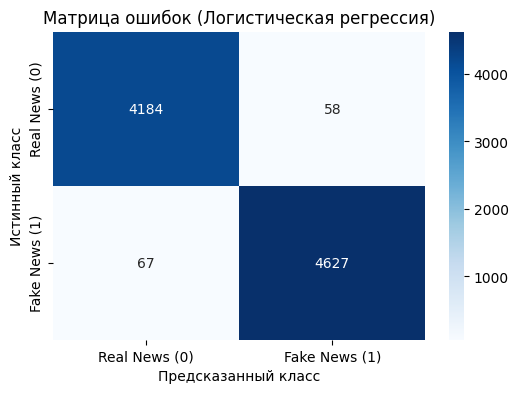

In [41]:
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real News (0)', 'Fake News (1)'], 
            yticklabels=['Real News (0)', 'Fake News (1)'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок (Логистическая регрессия)')
plt.show()

### Мультиномиальный Наивный Байес

In [42]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [43]:
y_pred_nb = nb_model.predict(X_test_tfidf)

print("Точность (Accuracy):", accuracy_score(y_test, y_pred_nb))
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred_nb, target_names=['Real News (0)', 'Fake News (1)']))

Точность (Accuracy): 0.9300581915846016

Отчет по классификации:
               precision    recall  f1-score   support

Real News (0)       0.94      0.92      0.93      4242
Fake News (1)       0.93      0.94      0.93      4694

     accuracy                           0.93      8936
    macro avg       0.93      0.93      0.93      8936
 weighted avg       0.93      0.93      0.93      8936



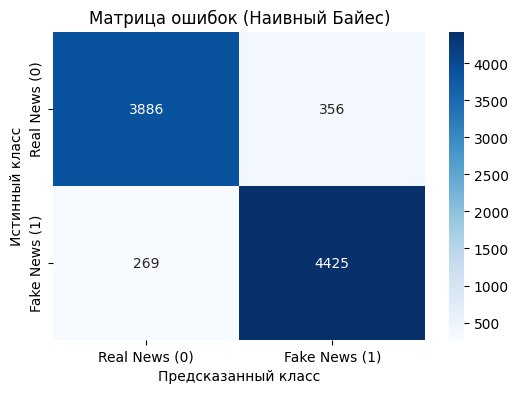

In [44]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real News (0)', 'Fake News (1)'], 
            yticklabels=['Real News (0)', 'Fake News (1)'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок (Наивный Байес)')
plt.show()

## TF-IDF - ngrams

In [45]:
tfidf_vectorizer_new = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.8,
)

X_train_tfidf_new = tfidf_vectorizer_new.fit_transform(X_train)
X_test_tfidf_new = tfidf_vectorizer_new.transform(X_test)

print(f"Размер нового словаря (количество признаков): {X_train_tfidf_new.shape[1]}")
print(f"Размеры новых TF-IDF матриц: X_train: {X_train_tfidf_new.shape}, X_test: {X_test_tfidf_new.shape}")

Размер нового словаря (количество признаков): 591672
Размеры новых TF-IDF матриц: X_train: (35744, 591672), X_test: (8936, 591672)


### Модель LinearSVC

In [46]:
lsvc_model = LinearSVC(random_state=RANDOM_STATE, C=0.5, max_iter=2000)
lsvc_model.fit(X_train_tfidf_new, y_train)

c:\Users\taras\university\fake_news\venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=0.5, max_iter=2000, random_state=42)

In [47]:
y_pred_lsvc = lsvc_model.predict(X_test_tfidf_new)

print("Точность (Accuracy) LinearSVC:", accuracy_score(y_test, y_pred_lsvc))
print("\nОтчет по классификации LinearSVC:")
print(classification_report(y_test, y_pred_lsvc, target_names=['Real News (0)', 'Fake News (1)'], zero_division=0))

Точность (Accuracy) LinearSVC: 0.9920546105640108

Отчет по классификации LinearSVC:
               precision    recall  f1-score   support

Real News (0)       0.99      0.99      0.99      4242
Fake News (1)       0.99      0.99      0.99      4694

     accuracy                           0.99      8936
    macro avg       0.99      0.99      0.99      8936
 weighted avg       0.99      0.99      0.99      8936



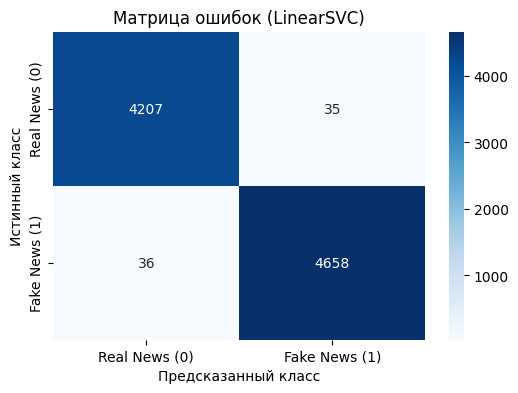

In [48]:
cm_lsvc = confusion_matrix(y_test, y_pred_lsvc)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lsvc, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real News (0)', 'Fake News (1)'], 
            yticklabels=['Real News (0)', 'Fake News (1)'])
plt.title('Матрица ошибок (LinearSVC)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

### Модель LGBMClassifier

In [49]:
lgbm_model = LGBMClassifier(random_state=RANDOM_STATE, n_estimators=200, learning_rate=0.1)
lgbm_model.fit(X_train_tfidf_new, y_train)

[LightGBM] [Info] Number of positive: 18775, number of negative: 16969
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 10.045244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1625614
[LightGBM] [Info] Number of data points in the train set: 35744, number of used features: 49671
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525263 -> initscore=0.101138
[LightGBM] [Info] Start training from score 0.101138


LGBMClassifier(n_estimators=200, random_state=42)

In [50]:
y_pred_lgbm = lgbm_model.predict(X_test_tfidf_new)

print("Точность (Accuracy) LGBMClassifier:", accuracy_score(y_test, y_pred_lgbm))
print("\nОтчет по классификации LGBMClassifier:")
print(classification_report(y_test, y_pred_lgbm, target_names=['Real News (0)', 'Fake News (1)'], zero_division=0))

Точность (Accuracy) LGBMClassifier: 0.9946284691136974

Отчет по классификации LGBMClassifier:
               precision    recall  f1-score   support

Real News (0)       1.00      0.99      0.99      4242
Fake News (1)       0.99      1.00      0.99      4694

     accuracy                           0.99      8936
    macro avg       0.99      0.99      0.99      8936
 weighted avg       0.99      0.99      0.99      8936



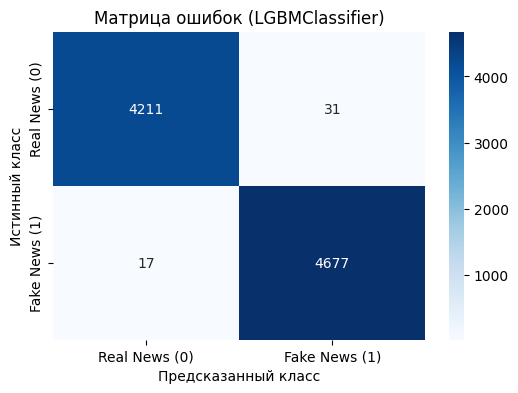

In [51]:
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real News (0)', 'Fake News (1)'], 
            yticklabels=['Real News (0)', 'Fake News (1)'])
plt.title('Матрица ошибок (LGBMClassifier)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

### Логистическая регрессия на новых признаках

In [52]:
print("\n\n--- Логистическая регрессия на НОВЫХ признаках (для сравнения) ---")
log_reg_model_new_tfidf = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)
log_reg_model_new_tfidf.fit(X_train_tfidf_new, y_train)



--- Логистическая регрессия на НОВЫХ признаках (для сравнения) ---


LogisticRegression(random_state=42, solver='liblinear')

In [53]:
y_pred_log_reg_new_tfidf = log_reg_model_new_tfidf.predict(X_test_tfidf_new)
print("Точность (Accuracy) LogReg с новыми TF-IDF:", accuracy_score(y_test, y_pred_log_reg_new_tfidf))
print("\nОтчет по классификации LogReg с новыми TF-IDF:")
print(classification_report(y_test, y_pred_log_reg_new_tfidf, target_names=['Real News (0)', 'Fake News (1)'], zero_division=0))

Точность (Accuracy) LogReg с новыми TF-IDF: 0.9862354521038496

Отчет по классификации LogReg с новыми TF-IDF:
               precision    recall  f1-score   support

Real News (0)       0.98      0.99      0.99      4242
Fake News (1)       0.99      0.99      0.99      4694

     accuracy                           0.99      8936
    macro avg       0.99      0.99      0.99      8936
 weighted avg       0.99      0.99      0.99      8936



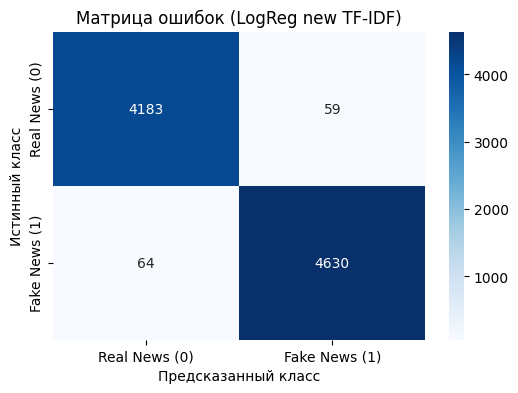

In [54]:
cm_lgbm = confusion_matrix(y_test, y_pred_log_reg_new_tfidf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real News (0)', 'Fake News (1)'], 
            yticklabels=['Real News (0)', 'Fake News (1)'])
plt.title('Матрица ошибок (LogReg new TF-IDF)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

Вывод: в итоге лучшими моделями показали себя LinearSVC и LGBMClassifier с использованием TfidfVectorizer с нграммами. Именно их мы и сохраним для дальнейшего использования

# Сохранение моделей

In [55]:
import pickle

with open('models/vectorizer_new.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer_new, file)

with open('models/lsvc_model_new.pkl', 'wb') as file:
    pickle.dump(lsvc_model, file)

with open('models/lgbm_model_new.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)